# Importing the necessary libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

In [2]:
choc = pd.read_csv('traintest.csv')

# One-hot encoding for categorical variables

In [3]:
# one hot encoding categoricals
choc_cat = choc[['country_of_bean_origin', 'first_taste', 'second_taste', 'third_taste', 'fourth_taste']]
choc_cat_ohe = pd.get_dummies(pd.DataFrame(choc_cat.values.tolist()),prefix_sep ='',prefix='')

# extracting rest of the predictors
choc_num = choc[['cocoa_percent', 'counts_of_ingredients', 'number_of_taste', 'vanilla', 'lecithin', 'salt', 'sugar']]

# extracting response
choc_response = choc['rating_category']

# combining predictors and response
choc_ohe = pd.concat([choc_cat_ohe, choc_response, choc_num], sort = False, axis = 1)
choc_ohe = choc_ohe.groupby(level=0, axis=1).sum().drop(columns='no taste')
choc_ohe

,Andes mint,Australia,Belize,Blend,Bolivia,Bolvia,Brazil,Burma,Cadbury egg,Cameroon,...,why bother,wild berry,wine,winey,wood,woodsy,woody,wtf,yellow fruit,yogurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For our models, we are going to use Stratified K Fold cross validation to evaluate the model, as well as calculating its accuracy rate on a training and testing data set

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, train_test_split

In [5]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

Extract response and predictor variables, and split train and test set

In [6]:
y = pd.DataFrame(choc_ohe['rating_category'])
X = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# Creating helper function for decision tree and random forest

In [7]:
def evalModel(classifier, X, y, scoring):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_validate(classifier, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    print('accuracy: %.3f (%.3f)' % (np.mean(n_scores["test_accuracy"]), np.std(n_scores["test_accuracy"])))
    print('precison: %.3f (%.3f)' % (np.mean(n_scores["test_precision"]), np.std(n_scores["test_precision"])))
    print('recall: %.3f (%.3f)' % (np.mean(n_scores["test_recall"]), np.std(n_scores["test_recall"])))
    print('f1 score: %.3f (%.3f)' % (np.mean(n_scores["test_f1_score"]), np.std(n_scores["test_f1_score"])))

def fitModel(classifier, X_train, X_test, y_train, y_test):
    # train thetree model
    classifier.fit(X_train, y_train.rating_category.ravel())

    # Predict Response corresponding to Predictors
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    # Check the Goodness of Fit on Train Data
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", classifier.score(X_train, y_train))
    print()
    # Check the Goodness of Fit on Test Data
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", classifier.score(X_test, y_test))
    print()

    trainData = confusion_matrix(y_train, y_train_pred)
    testData = confusion_matrix(y_test, y_test_pred)

    print("True '1' rate Train :\t", (trainData[1][1]/(trainData[1][0]+trainData[1][1])))
    print("True '0' rate Train :\t", (trainData[0][0]/(trainData[0][0]+trainData[0][1])))
    print()
    print("False '1' rate Train :\t", ((trainData[0][1])/((trainData[0][1]+trainData[0][0]))))
    print("False '0' rate Train :\t", ((trainData[1][0])/((trainData[1][0]+trainData[1][1]))))
    print()
    print("True '1' rate Test :\t", (testData[1][1]/(testData[1][0]+testData[1][1])))
    print("True '0' rate Test :\t", (testData[0][0]/(testData[0][0]+testData[0][1])))
    print()
    print("False '1' rate Test :\t", ((testData[0][1])/((testData[0][1]+testData[0][0]))))
    print("False '0' rate Test :\t", ((testData[1][0])/((testData[1][0]+testData[1][1]))))
    print()

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(2, 1, figsize=(8, 16))
    sb.heatmap(trainData, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(testData,  annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Classification tree

We start off with a very simple model, a decision tree classifier

In [8]:
from sklearn.tree import DecisionTreeClassifier

Using stratified K fold cross validation to evaluate the model

In [9]:
dectree = DecisionTreeClassifier(max_depth = 40)
evalModel(dectree, X, y, scoring)

accuracy: 0.675 (0.015)
precison: 0.696 (0.014)
recall: 0.777 (0.019)
f1 score: 0.734 (0.013)


Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9212158808933002

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.684863523573201

True '1' rate Train :	 1.0
True '0' rate Train :	 0.8135095447870778

False '1' rate Train :	 0.18649045521292218
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8369098712446352
True '0' rate Test :	 0.4764705882352941

False '1' rate Test :	 0.5235294117647059
False '0' rate Test :	 0.1630901287553648



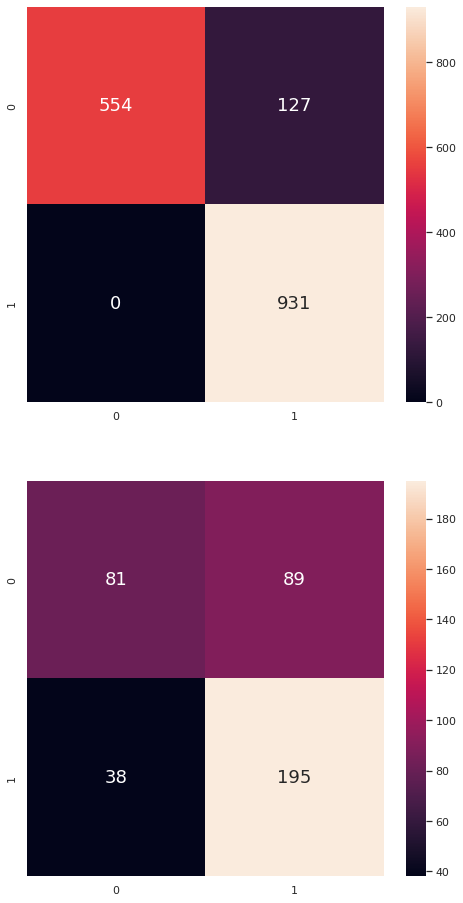

In [10]:
fitModel(dectree, X_train, X_test, y_train, y_test)

Overall, the Classification Tree model did quite a bad job of predicting our chocolate rating, let's see how we can improve upon that accuracy.

# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

Using stratified K fold cross validation to evaluate the model

In [12]:
rforest = RandomForestClassifier(n_estimators = 800, max_depth = 80)
evalModel(rforest, X, y, scoring)

accuracy: 0.723 (0.020)
precison: 0.722 (0.015)
recall: 0.845 (0.031)
f1 score: 0.779 (0.018)


Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.999379652605459

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6823821339950372

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9985315712187959

False '1' rate Train :	 0.0014684287812041115
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8412017167381974
True '0' rate Test :	 0.4647058823529412

False '1' rate Test :	 0.5352941176470588
False '0' rate Test :	 0.15879828326180256



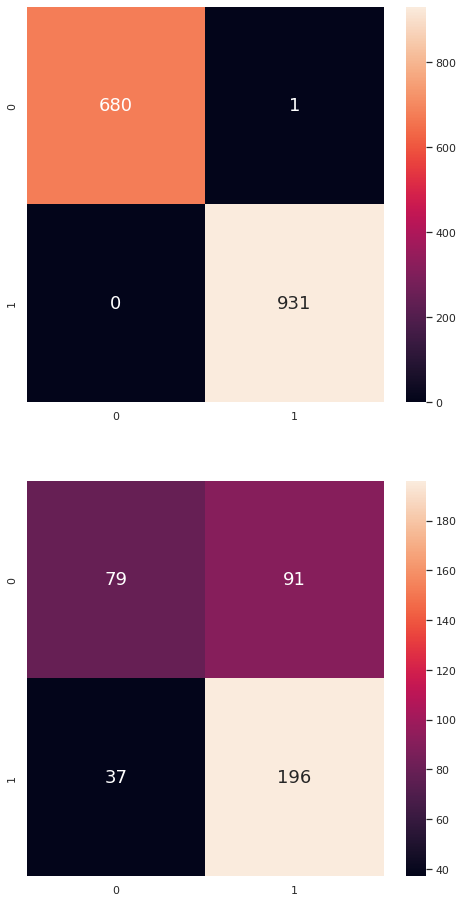

In [13]:
fitModel(rforest, X_train, X_test, y_train, y_test)

We have good accuracy on the training data set, but horrible accuracy on the test dataset, this might be a case of overfitting.
We predict too much '0' value as '1', which can mess with our prediction of a highly rated chocolate bar

# Upsampling the minority class in rating category

In [14]:
# See which category of rating is imbalanced
choc_ohe.rating_category.value_counts()

1.0    1164
0.0     851
Name: rating_category, dtype: int64

In [15]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [16]:
rforest = RandomForestClassifier(n_estimators = 600, max_depth = 60)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5) 
steps = [("smote", over),("model", rforest)]
pipeline = Pipeline(steps = steps)

Experimented with different kind of SMOTE algorithms, including SMOTE, SVMSMOTE, BorderlineSMOTE, KMeansSMOTE and ADASYN.
Found that ADASYN generally resulted in the best parameters

Using stratified K fold cross validation to evalute the model

In [17]:
evalModel(pipeline, X, y, scoring)

accuracy: 0.722 (0.018)
precison: 0.727 (0.013)
recall: 0.832 (0.031)
f1 score: 0.776 (0.017)


Test the model on a train and test data set

In [18]:
y_train.value_counts()

rating_category
1.0                931
0.0                681
dtype: int64

In [19]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1.0                931
0.0                856
dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9899272523782876

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6799007444168734

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9789719626168224

False '1' rate Train :	 0.02102803738317757
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8412017167381974
True '0' rate Test :	 0.4588235294117647

False '1' rate Test :	 0.5411764705882353
False '0' rate Test :	 0.15879828326180256



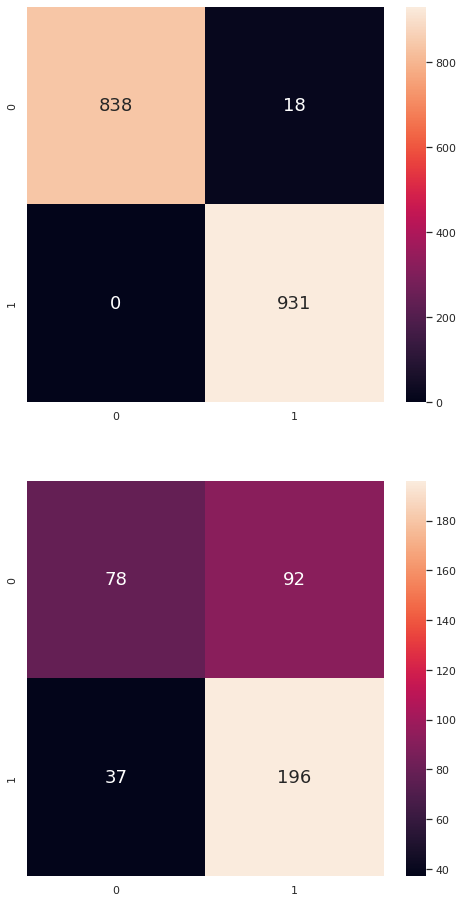

In [20]:
fitModel(rforest, X_train_res, X_test, y_train_res, y_test)

Better accuracy, and better recall rate as well

# Removing minority classes in predictors

In [21]:
beanOriginCounts = pd.DataFrame(choc['country_of_bean_origin'].value_counts())
beanOriginTop = beanOriginCounts[beanOriginCounts['country_of_bean_origin'] > 40].reset_index()
beanOriginTop

,index,country_of_bean_origin
0,Venezuela,220
1,Peru,188
2,Dominican republic,182
3,Ecuador,159
4,Madagascar,151
5,Blend,101
6,Nicaragua,87
7,Bolivia,67
8,Brazil,65
9,Tanzania,62


In the column `country_of_bean_origin`, there are a lot of data which only appeared very few times.

In [22]:
choc_xoutlier = choc[choc["country_of_bean_origin"].isin(beanOriginTop["index"])].reset_index(drop=True)
choc_xoutlier

,country_of_bean_origin,cocoa_percent,rating_category,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,first_taste,second_taste,third_taste,fourth_taste,number_of_taste
0,Madagascar,76.0,1,3.75,3,1,0,0,0,1,cocoa,blackberry,full body,no taste,3
1,Dominican republic,76.0,1,3.50,3,1,0,0,0,1,cocoa,vegetal,savory,no taste,3
2,Tanzania,76.0,1,3.25,3,1,0,0,0,1,rich cocoa,fatty,bready,no taste,3
3,Bolivia,70.0,1,3.50,4,1,0,1,0,1,vegetal,nutty,no taste,no taste,2
4,Venezuela,70.0,1,4.00,4,1,0,1,0,1,oily,nut,caramel,raspberry,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,Papua new guinea,75.0,0,3.00,4,1,0,0,1,0,hint of smoke,fruit,no taste,no taste,2
1599,Blend,80.0,0,2.75,4,1,0,0,1,0,waxy,cloying,vegetal,no taste,3
1600,Colombia,75.0,1,3.75,3,1,0,0,0,1,strong nutty,marshmallow,no taste,no taste,2
1601,Belize,72.0,1,3.50,3,1,0,0,0,1,muted,roasty,accessible,no taste,3


In [23]:
# one hot encoding categoricals
choc_cat = choc_xoutlier[['country_of_bean_origin', 'first_taste', 'second_taste', 'third_taste', 'fourth_taste']]
choc_cat_ohe = pd.get_dummies(pd.DataFrame(choc_cat.values.tolist()),prefix_sep ='',prefix='')

# extracting rest of the predictors
choc_num = choc_xoutlier[['cocoa_percent', 'counts_of_ingredients', 'number_of_taste', 'vanilla', 'lecithin', 'salt', 'sugar']]

# extracting response
choc_response = pd.DataFrame(choc_xoutlier['rating_category'])

# combining predictors and response
choc_xoutlier_ohe = pd.concat([choc_cat_ohe, choc_response, choc_num], sort = False, axis = 1)
choc_xoutlier_ohe = choc_xoutlier_ohe.groupby(level=0, axis=1).sum().drop(columns='no taste')
choc_xoutlier_ohe

,Belize,Blend,Bolivia,Brazil,Cadbury egg,Colombia,Dominican republic,Easter candy,Ecuador,Fruity,...,why bother,wild berry,wine,winey,wood,woodsy,woody,wtf,yellow fruit,yogurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1599,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1600,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
choc_xoutlier_ohe.rating_category.value_counts()

1.0    945
0.0    658
Name: rating_category, dtype: int64

In [25]:
y = pd.DataFrame(choc_xoutlier_ohe['rating_category'])
X = pd.DataFrame(choc_xoutlier_ohe.drop('rating_category', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [26]:
rforest = RandomForestClassifier(n_estimators = 400, max_depth = 60)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5) 
steps = [("smote", over),("model", rforest)]
pipeline = Pipeline(steps = steps)

Using stratified K fold cross validation to evalute the model

In [27]:
evalModel(rforest, X, y, scoring)

accuracy: 0.713 (0.023)
precison: 0.713 (0.020)
recall: 0.861 (0.025)
f1 score: 0.779 (0.017)


Test the model on a train and test data set

In [28]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1.0                756
0.0                665
dtype: int64

Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9992962702322308

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7320872274143302

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9984962406015038

False '1' rate Train :	 0.0015037593984962407
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8465608465608465
True '0' rate Test :	 0.5681818181818182

False '1' rate Test :	 0.4318181818181818
False '0' rate Test :	 0.15343915343915343



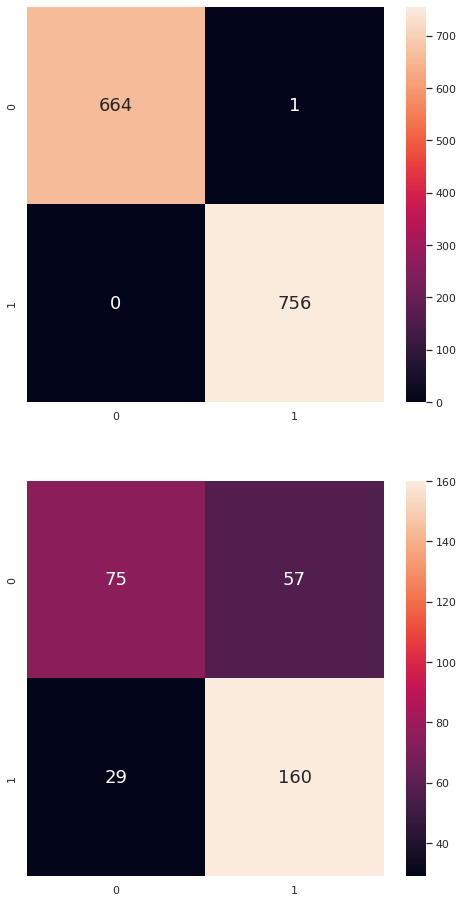

In [29]:
fitModel(rforest, X_train_res, X_test, y_train_res, y_test)

To add comment here

# Gradient Boosting

Let's try a more sophisticated model, Gradient Boosting Machine

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
# gradient boosting for classification in scikit-learn

In [31]:
GradBoost = GradientBoostingClassifier(loss = "deviance", learning_rate = 0.1, n_estimators = 500, subsample = 0.5, max_depth = 6)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5) 
steps = [("smote", over),("model", GradBoost)]
pipeline = Pipeline(steps = steps)

Using stratified K fold cross validation to evalute the model

In [32]:
evalModel(pipeline, X, y, scoring)

accuracy: 0.723 (0.020)
precison: 0.750 (0.018)
recall: 0.797 (0.032)
f1 score: 0.772 (0.018)


Test the model on a train and test data set

In [33]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1.0                756
0.0                665
dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9978888106966924

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7414330218068536

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9954887218045113

False '1' rate Train :	 0.004511278195488722
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8095238095238095
True '0' rate Test :	 0.6439393939393939

False '1' rate Test :	 0.3560606060606061
False '0' rate Test :	 0.19047619047619047



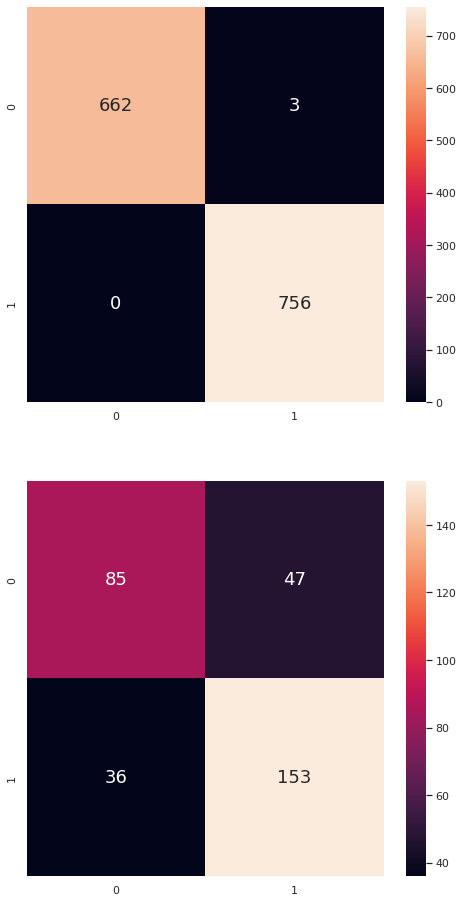

In [34]:
fitModel(GradBoost, X_train_res, X_test, y_train_res, y_test)

## Without removing outliers

In [35]:
y = pd.DataFrame(choc_ohe['rating_category'])
X = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [36]:
y_train.rating_category.value_counts()

1.0    931
0.0    681
Name: rating_category, dtype: int64

In [37]:
GradBoost = GradientBoostingClassifier(loss = "deviance", learning_rate = 0.08, n_estimators = 700, subsample = 0.8, max_depth = 9)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [("smote", over),("model", GradBoost)]
pipeline = Pipeline(steps = steps)

In [38]:
evalModel(pipeline, X, y, scoring)

accuracy: 0.725 (0.021)
precison: 0.742 (0.017)
recall: 0.803 (0.028)
f1 score: 0.771 (0.019)


In [39]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1.0                931
0.0                859
dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7245657568238213

True '1' rate Train :	 1.0
True '0' rate Train :	 1.0

False '1' rate Train :	 0.0
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8111587982832618
True '0' rate Test :	 0.6058823529411764

False '1' rate Test :	 0.3941176470588235
False '0' rate Test :	 0.1888412017167382



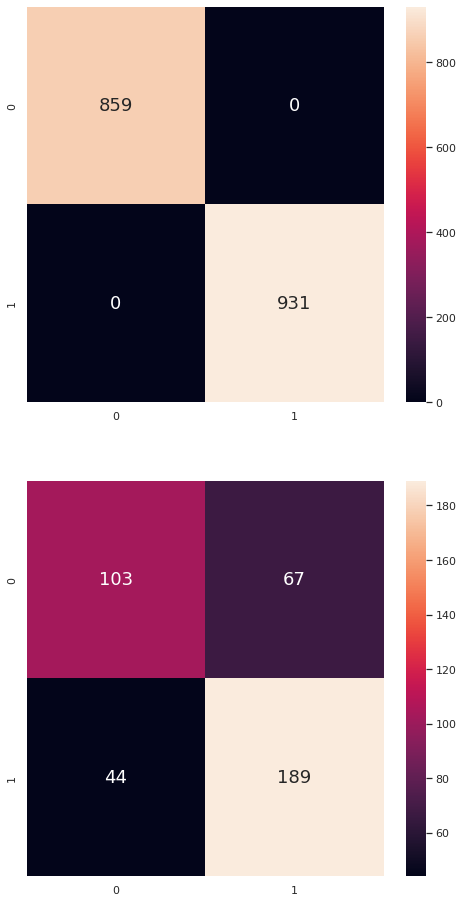

In [40]:
fitModel(GradBoost, X_train_res, X_test, y_train_res, y_test)